使用茅台数据：
1，格兰威尔法则策略
2，布林线策略
3，变点检验（策略的切换）

Starting Portfolio Value: 1000.00
--- Position Begin
- Size: 0
- Price: 0.0
- Price orig: 0.0
- Closed: 0
- Opened: 0
- Adjbase: None
--- Position End
decreasing
有趋势,使用均线法则
2007-01-31, SELL CREATE, 15.26
2007-02-01, SELL EXECUTED, Price: 15.32, Cost: -153.20, Comm 0.00, Size -10.00
--- Position Begin
- Size: -10
- Price: 15.32
- Price orig: 0.0
- Closed: 0
- Opened: -10
- Adjbase: 15.17
--- Position End
decreasing
有趋势,使用均线法则
2007-02-01, SELL CREATE, 15.17
2007-02-02, SELL EXECUTED, Price: 15.25, Cost: -152.50, Comm 0.00, Size -10.00
--- Position Begin
- Size: -20
- Price: 15.285
- Price orig: 15.32
- Closed: 0
- Opened: -10
- Adjbase: 15.49
--- Position End
decreasing
有趋势,使用均线法则
2007-02-02, close short, 15.49
2007-02-05, BUY EXECUTED, Price: 15.43, Cost: -305.70, Comm 0.00, Size 20.00
2007-02-05, OPERATION PROFIT, GROSS -2.90, NET -2.90
--- Position Begin
- Size: 0
- Price: 0.0
- Price orig: 15.285
- Closed: 20
- Opened: 0
- Adjbase: 15.49
--- Position End
decreasing
有趋势,使用均线法则
2007-02

<IPython.core.display.Javascript object>


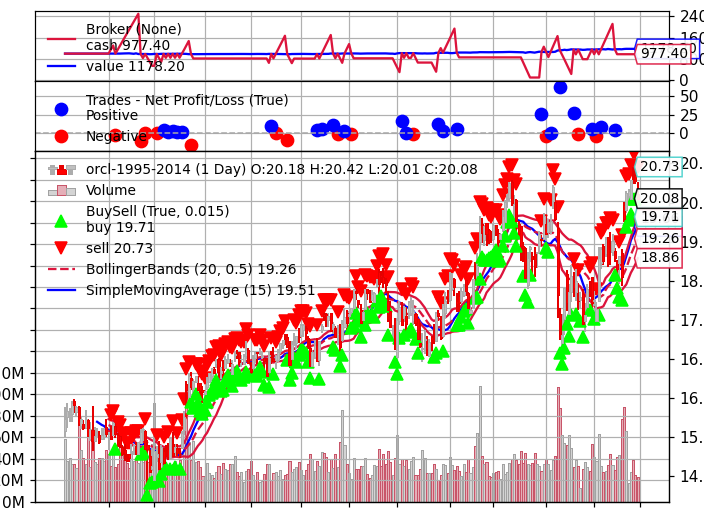

In [99]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])

# Import the backtrader platform
import backtrader as bt
import numpy as np
import pymannkendall as mk

# Create a Stratey
class TestStrategy(bt.Strategy):
    params = (
        ('maperiod', 15),('trend_test_period', 20), ("period", 20), ("devfactor", 0.5), ("debug", False), ("size", 1),
        ("trail", False), ("stop_loss", 0.02)
    )

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        self.data_trend_test = self.datas[0].get(size=self.p.trend_test_period)  # ago defaults to 0
        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None
        #设置变点检验的区间
        #初始化布林线
        self.boll = bt.indicators.BollingerBands(period=self.p.period, devfactor=self.p.devfactor)
        # Add a MovingAverageSimple indicator
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.maperiod)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f, Size %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm,
                     order.executed.size))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f, Size %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm,
                          order.executed.size))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        print(self.position)
        #进行趋势检验
        self.trend_test_data = self.data.get(size=self.params.trend_test_period)
        trend, h, p, z, Tau, s, var_s, slope, intercept = mk.original_test(self.trend_test_data)
        print(trend)
        #没有趋势时，用布林线法则
        if trend == 'no trend':
            print('没有趋势,使用布林线法则')
            #已经是多头的情形
            if self.position.size > 0:
                if self.data.close < self.boll.lines.bot:
                    self.log('BUY CREATE, %.2f' % self.dataclose[0])
                    self.order = self.buy()
                else:
                    self.log('close long, %.2f' % self.dataclose[0])
                    self.order = self.close()
            #已经是空头的情形
            if self.position.size < 0:
                if self.data.close > self.boll.lines.top:
                    self.log('SELL CREATE, %.2f' % self.dataclose[0])
                    self.order = self.sell() 
                else:
                    self.log('close short, %.2f' % self.dataclose[0])
                    self.order = self.close()
            #还没有持仓的情形
            if self.position.size == 0:
                if self.data.close > self.boll.lines.top:
                    self.log('SELL CREATE, %.2f' % self.dataclose[0])
                    self.order = self.sell() 
                else:
                    self.log('close short, %.2f' % self.dataclose[0])
                    self.order = self.buy()
        else:  
            print('有趋势,使用均线法则')
            if self.order:
                return
            #已经是多头的情形
            if self.position.size > 0:
                if self.dataclose[0] > self.sma[0]:
                    self.log('BUY CREATE, %.2f' % self.dataclose[0])
                    self.order = self.buy()
                if self.dataclose[0] > self.sma[0]:
                    self.log('close long, %.2f' % self.dataclose[0])
                    self.order = self.close()
            #已经是空头的情形
            if self.position.size < 0:
                if self.dataclose[0] > self.sma[0]:
                    self.log('close short, %.2f' % self.dataclose[0])
                    self.order = self.close()
                if self.dataclose[0] < self.sma[0]:
                    self.log('SELL CREATE, %.2f' % self.dataclose[0])
                    self.order = self.sell()
            #还没有持仓的情形
            if self.position.size == 0:
                if self.dataclose[0] > self.sma[0]:
                    self.log('close short, %.2f' % self.dataclose[0])
                    self.order = self.buy()
                if self.dataclose[0] < self.sma[0]:
                    self.log('SELL CREATE, %.2f' % self.dataclose[0])
                    self.order = self.sell()

if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(TestStrategy)

    # Datas are in a subfolder of the samples. Need to find where the script is
    # because it could have been called from anywhere
    modpath = os.path.dirname(os.path.abspath(sys.argv[1]))
    datapath = os.path.join(modpath, 'D:\desktop\orcl-1995-2014.txt')

    # Create a Data Feed
    data = bt.feeds.YahooFinanceCSVData(
        dataname=datapath,
        # Do not pass values before this date
        fromdate=datetime.datetime(2007, 1, 1),
        # Do not pass values before this date
        todate=datetime.datetime(2008, 1, 1),
        # Do not pass values after this date
        reverse=False)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(1000.0)

    # Add a FixedSize sizer according to the stake
    cerebro.addsizer(bt.sizers.FixedSize, stake=10)

    # Set the commission
    cerebro.broker.setcommission(commission=0.0)

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    cerebro.plot(style='candlestick')

直接用布林线法则

Starting Portfolio Value: 1000.00
2007-01-31, Close, 15.26
array('d', [15.57, 15.73, 15.69, 15.89, 15.85, 15.81, 15.47, 15.57, 15.39, 15.58, 15.23, 15.36, 15.12, 15.23, 15.25, 15.1, 15.25, 15.36, 15.26, 15.26])
decreasing
2007-01-31, BUY CREATE, 15.26
2007-02-01, BUY EXECUTED, Price: 15.32, Cost: 153.20, Comm 0.00
2007-02-01, Close, 15.17
array('d', [15.73, 15.69, 15.89, 15.85, 15.81, 15.47, 15.57, 15.39, 15.58, 15.23, 15.36, 15.12, 15.23, 15.25, 15.1, 15.25, 15.36, 15.26, 15.26, 15.17])
decreasing
2007-02-02, Close, 15.49
array('d', [15.69, 15.89, 15.85, 15.81, 15.47, 15.57, 15.39, 15.58, 15.23, 15.36, 15.12, 15.23, 15.25, 15.1, 15.25, 15.36, 15.26, 15.26, 15.17, 15.49])
decreasing
2007-02-05, Close, 15.26
array('d', [15.89, 15.85, 15.81, 15.47, 15.57, 15.39, 15.58, 15.23, 15.36, 15.12, 15.23, 15.25, 15.1, 15.25, 15.36, 15.26, 15.26, 15.17, 15.49, 15.26])
decreasing
2007-02-06, Close, 15.14
array('d', [15.85, 15.81, 15.47, 15.57, 15.39, 15.58, 15.23, 15.36, 15.12, 15.23, 15.25, 15.1, 

<IPython.core.display.Javascript object>


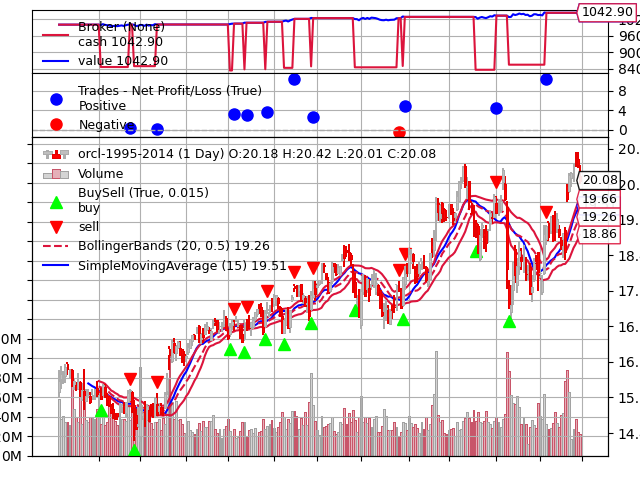

In [37]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])

# Import the backtrader platform
import backtrader as bt
import numpy as np
import pymannkendall as mk

# Create a Stratey
class TestStrategy(bt.Strategy):
    params = (
        ('maperiod', 15),('trend_test_period', 20), ("period", 20), ("devfactor", 0.5), ("debug", False)
    )

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        self.data_trend_test = self.datas[0].get(size=10)  # ago defaults to 0
        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None
        #设置变点检验的区间
        #初始化布林线
        self.boll = bt.indicators.BollingerBands(period=self.p.period, devfactor=self.p.devfactor)
        # Add a MovingAverageSimple indicator
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.maperiod)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])
        #进行趋势检验
        self.trend_test_data = self.data.get(size=self.params.trend_test_period)
        trend, h, p, z, Tau, s, var_s, slope, intercept = mk.original_test(self.trend_test_data)
        print(self.trend_test_data )
        print(trend)
        #直接用布林线法则
        if not self.position:
            if self.data.close < self.boll.lines.bot:
                self.log('BUY CREATE, %.2f' % self.dataclose[0])
                self.order = self.buy()
        else:
            if self.data.close > self.boll.lines.top:
                self.log('SELL CREATE, %.2f' % self.dataclose[0])
                self.order = self.sell()


if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(TestStrategy)

    # Datas are in a subfolder of the samples. Need to find where the script is
    # because it could have been called from anywhere
    modpath = os.path.dirname(os.path.abspath(sys.argv[1]))
    datapath = os.path.join(modpath, 'D:\desktop\orcl-1995-2014.txt')

    # Create a Data Feed
    data = bt.feeds.YahooFinanceCSVData(
        dataname=datapath,
        # Do not pass values before this date
        fromdate=datetime.datetime(2007, 1, 1),
        # Do not pass values before this date
        todate=datetime.datetime(2008, 1, 1),
        # Do not pass values after this date
        reverse=False)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(1000.0)

    # Add a FixedSize sizer according to the stake
    cerebro.addsizer(bt.sizers.FixedSize, stake=10)

    # Set the commission
    cerebro.broker.setcommission(commission=0.0)

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    cerebro.plot(style='candlestick')

直接用均线策略

Starting Portfolio Value: 1000.00
2007-01-31, Close, 15.26
array('d', [15.57, 15.73, 15.69, 15.89, 15.85, 15.81, 15.47, 15.57, 15.39, 15.58, 15.23, 15.36, 15.12, 15.23, 15.25, 15.1, 15.25, 15.36, 15.26, 15.26])
decreasing
2007-02-01, Close, 15.17
array('d', [15.73, 15.69, 15.89, 15.85, 15.81, 15.47, 15.57, 15.39, 15.58, 15.23, 15.36, 15.12, 15.23, 15.25, 15.1, 15.25, 15.36, 15.26, 15.26, 15.17])
decreasing
2007-02-02, Close, 15.49
array('d', [15.69, 15.89, 15.85, 15.81, 15.47, 15.57, 15.39, 15.58, 15.23, 15.36, 15.12, 15.23, 15.25, 15.1, 15.25, 15.36, 15.26, 15.26, 15.17, 15.49])
decreasing
2007-02-02, BUY CREATE, 15.49
2007-02-05, BUY EXECUTED, Price: 15.43, Cost: 154.30, Comm 0.00
2007-02-05, Close, 15.26
array('d', [15.89, 15.85, 15.81, 15.47, 15.57, 15.39, 15.58, 15.23, 15.36, 15.12, 15.23, 15.25, 15.1, 15.25, 15.36, 15.26, 15.26, 15.17, 15.49, 15.26])
decreasing
2007-02-05, SELL CREATE, 15.26
2007-02-06, SELL EXECUTED, Price: 15.24, Cost: 154.30, Comm 0.00
2007-02-06, OPERATION PR

<IPython.core.display.Javascript object>


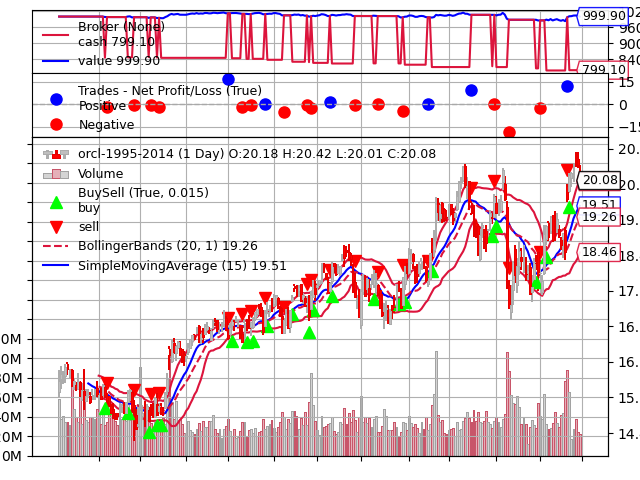

In [33]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])

# Import the backtrader platform
import backtrader as bt
import numpy as np
import pymannkendall as mk

# Create a Stratey
class TestStrategy(bt.Strategy):
    params = (
        ('maperiod', 15),('trend_test_period', 20), ("period", 20), ("devfactor", 1), ("debug", False)
    )

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        self.data_trend_test = self.datas[0].get(size=10)  # ago defaults to 0
        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None
        #设置变点检验的区间
        #初始化布林线
        self.boll = bt.indicators.BollingerBands(period=self.p.period, devfactor=self.p.devfactor)
        # Add a MovingAverageSimple indicator
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.maperiod)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])
        #进行趋势检验
        self.trend_test_data = self.data.get(size=self.params.trend_test_period)
        trend, h, p, z, Tau, s, var_s, slope, intercept = mk.original_test(self.trend_test_data)
        print(self.trend_test_data )
        print(trend)
        #直接用均线法则
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] > self.sma[0]:

                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()

        else:

            if self.dataclose[0] < self.sma[0]:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()


if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(TestStrategy)

    # Datas are in a subfolder of the samples. Need to find where the script is
    # because it could have been called from anywhere
    modpath = os.path.dirname(os.path.abspath(sys.argv[1]))
    datapath = os.path.join(modpath, 'D:\desktop\orcl-1995-2014.txt')

    # Create a Data Feed
    data = bt.feeds.YahooFinanceCSVData(
        dataname=datapath,
        # Do not pass values before this date
        fromdate=datetime.datetime(2007, 1, 1),
        # Do not pass values before this date
        todate=datetime.datetime(2008, 1, 1),
        # Do not pass values after this date
        reverse=False)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(1000.0)

    # Add a FixedSize sizer according to the stake
    cerebro.addsizer(bt.sizers.FixedSize, stake=10)

    # Set the commission
    cerebro.broker.setcommission(commission=0.0)

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    cerebro.plot(style='candlestick')